# The Evolution of Cooperative and Defective Institutions
![bees](https://beelab.umn.edu/sites/beelab.umn.edu/files/styles/folwell_full/public/2021-05/learn%20about%20honey%20bees%20header.jpg?itok=tXHHAxNX)

### Previous Work
1) Axelrod, R. 1984. The Evolution of Cooperation

2) Ostrom, E. 1990. Governing the Commons: The Evolution of Institutions for Collective Action

3) Miller, J. H. 2022. Ex Machina: Coevolving Machines and the Origins of the Social Universe

Previous work has developed the ideas of evolutionary game theory for strategies and the importance of evolution for institutions, but none has yet modeled the dynamic institutions themselves. 

### Hypothesis
1) Evolutionary institutions will be capable of evolving cooperation but this outcome may be less common and less stable than defection with sufficiently small numbers of rounds. 

2) Increasing the number of rounds increases cooperation. 

3) If cooperation does arise, then the institution should move towards maximizing the reward of cooperation. Similarly, if defection dominates, then the institutions should move towards maximizing the reward of defection.

## Institutions

### Prisoner's Dilemma
The Prisoner's Dilemma is defined as a two player game with the following payoff structure where $S < P < R < T$. This gives the characteristic trait of the Prisoner's Dilemma: defecting strictly dominates cooperation in one-shot games. 

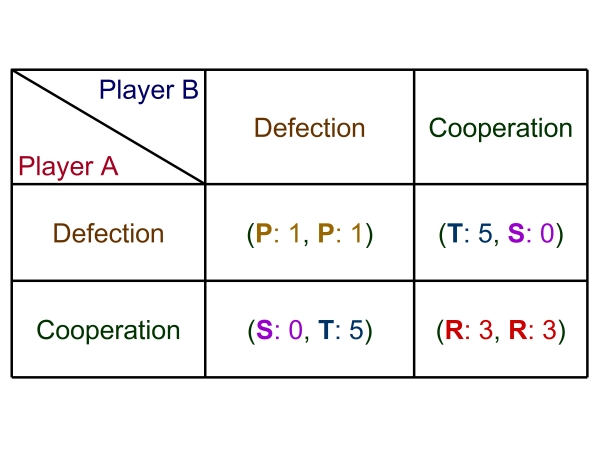

Because we consider the iterated Prisoner's Dilemma, we add the constraint that $\frac{T + S}{2} < R$ to prvent alternating between duping and getting duped being better for both players than cooperating. 

### Definition of an Institution
An institution is defined as the tuple $(P, R, T)$ wlog.

1) $0 < P < R < T$

2) $½T < R$

3) $P + R + T = 1$ 

This third constraint ensures that institutions don't have their payoffs go to infinity. 

This gives us the following payoff space: 

![gif](https://cdn.discordapp.com/attachments/1046823579246927903/1181091224531251250/PRT_Space_Visualization.gif?ex=657fcbeb&is=656d56eb&hm=1efe1b6c5f28bb31c4ed453e03c6f5994594089d8352b99ee9234f130819abf9&)

$R$ maximizing institution: $(0,  ½, ½)$ 

$P$ maximizing institution: $(⅓, ⅓, ⅓)$

## Automata
Automata—or finite discrete state machines—possess the following qualities: 
1) $n$ states (one of which is the initial state) 
2) each state has an output
3) each state has a transition defined for each possible input (states can transition to themselves) 

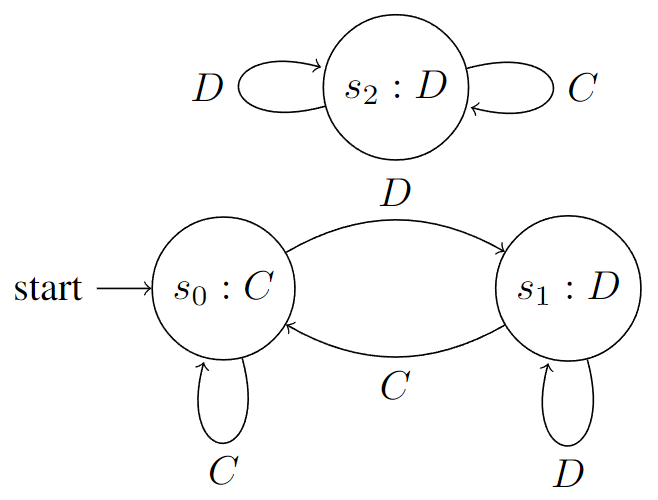

## Evolution
### Selection By Performance
Within a generation:
1) Each agent plays each other twice
    1) Once for each institution
2) Gets a score based on the sum of their payoffs
3) Randomly sample (with replacement) two agents for each new agent
4) Agent with a higher score continues to the next generation
5) Probability of mutation

### Automata Evolution
Half of mutations affect the agent's automaton:
1) Select a state randomly
2) Randomly decide to change the state's output or a transition
3) Select which transition if a transition is being changed
4) Randomly select new output or transition

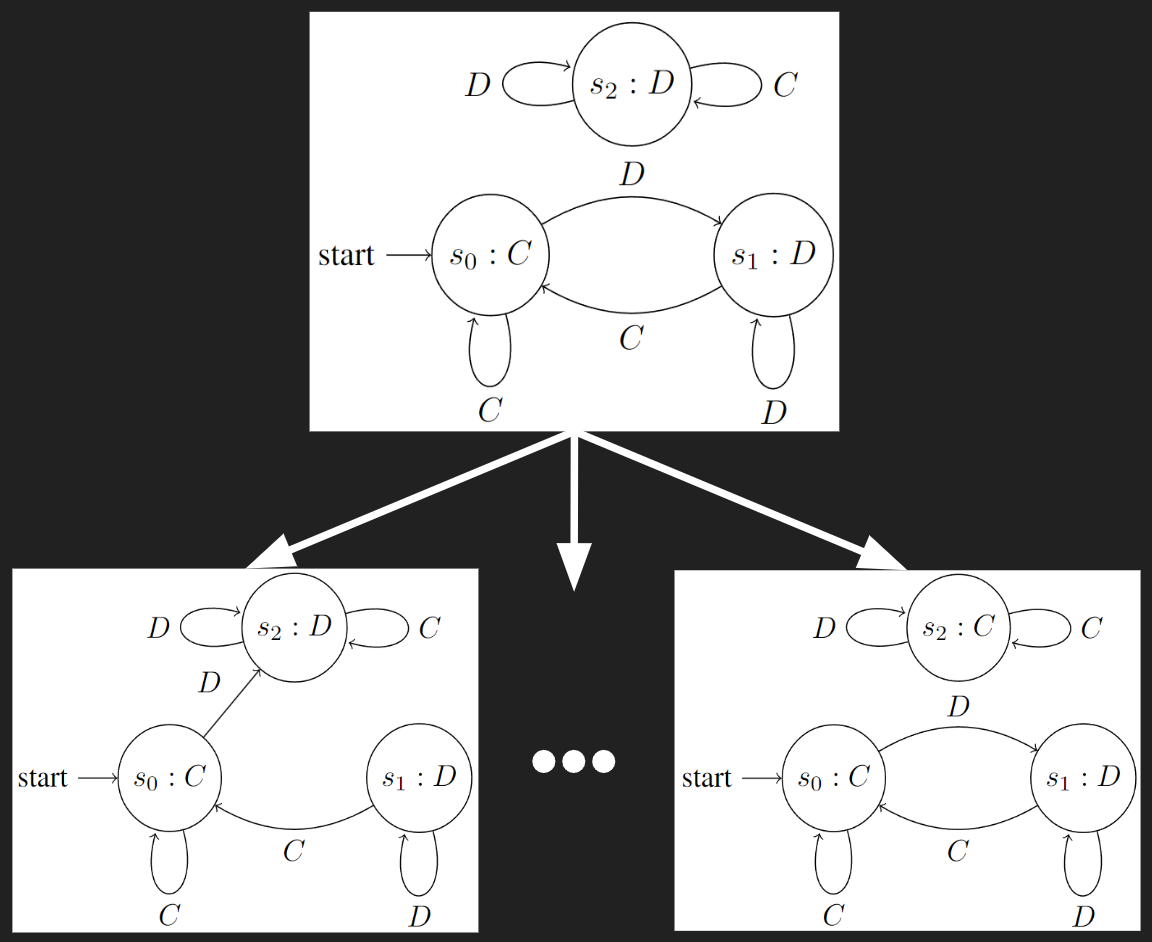

### Institution Evolution
Half of mutations affect that agent's institution 

Represent $(P, R, T)$ using the $PR$ and $RT$ bounds. 

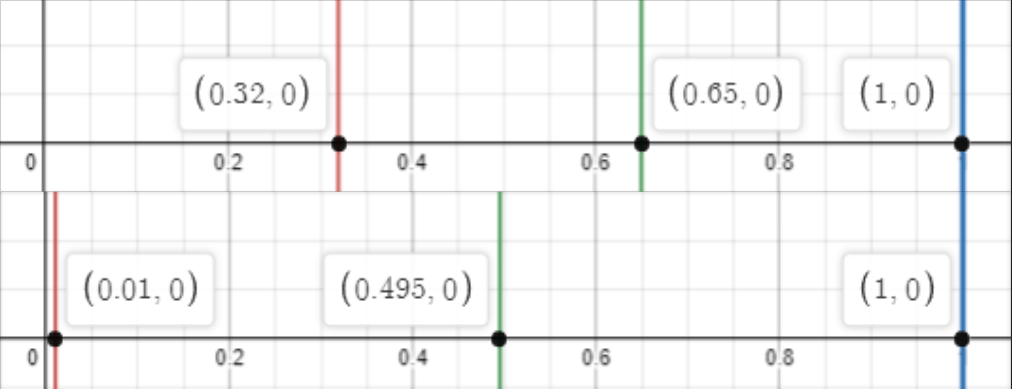

Sample mutated values from bivariate t-distribution

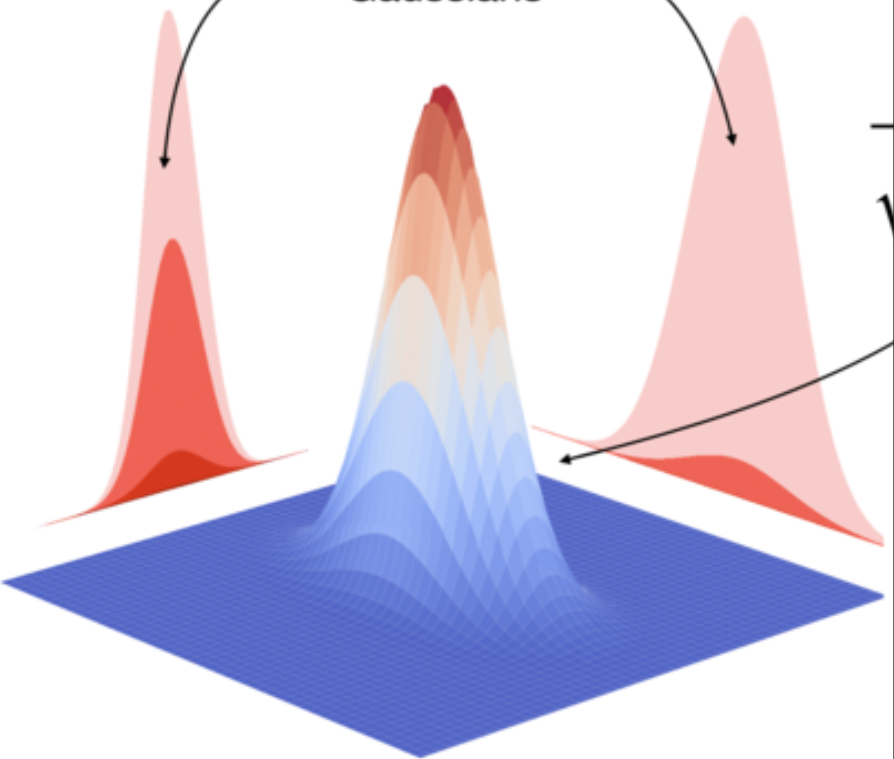

# Implemenation

## Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import time
import datetime
import logging
import cProfile
import random
from math import factorial
from numba import njit
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind
import scipy.stats as stats
import seaborn as sns
import subprocess
import matplotlib

## Instition Mutation

In [6]:
# Mutate Institution Bounds using t distribution
@njit
def mutate_bounds_t(current_values, df=30, step_size=0.01):
    """
    Generate a sample from a distribution using the Student's t-distribution for mass allocation bounds.
    Ensures the sample satisfies the constraints 0 < PR_bound < RT_bound - PR_bound < 1 - RT_bound 
    and 1/2*(1 - RT_bound) < RT_bound - PR_bound.

    :param current_values: The vector of current valuesfor PR_bound and RT_bound.
    :param df: Degrees of freedom for the t-distribution.
    :param var: Scaling factor for the t-distribution.
    :return: A valid sample as a numpy array [PR_bound, RT_bound].
    """
    while True:
        # Generate PR_bound and RT_bound using the Student's t-distribution
        PR_bound = current_values[0] + np.random.standard_t(df) * step_size
        RT_bound = current_values[1] + np.random.standard_t(df) * step_size

        # Check if generated values satisfy the constraints
        if 0 < PR_bound < RT_bound - PR_bound < 1 - RT_bound \
                and 1/2*(1 - RT_bound) < RT_bound - PR_bound:
            return np.array([PR_bound, RT_bound])

## Simulation Code

In [7]:
# Run Endogenous Institutions using Bounded Implemenation
@njit
def run_endogenous_institutions_bounded(
            n_trials:int, 
            n_generations:int = 200,
            n_agents:int = 50, 
            n_rounds:int = 5, 
            n_states:int = 3, 
            mutate_prob:float = 1/3,
            average_increment:float = 0.01,
            df:int = 1,
            dual_games:bool = True
):   
    """
    Description:
    -------------
    Simulates the evolution of automata agents and their institutions in a game-theoretic context. 
    Automata and institutions undergo performance-based evolution over multiple generations. The function 
    leverages the numba library's `njit` decorator for performance optimization.

    Parameters:
    -------------
    - n_trials (int): 
        Number of trials for each game specification.
    
    - n_generations (int, optional): 
        Number of generations for automata evolution in each trial (default=200).

    - n_agents (int, optional): 
        Number of automata agents in the population (default=50).

    - n_rounds (int, optional): 
        Number of rounds in the Prisoner's Dilemma game per generation (default=5).

    - n_states (int, optional): 
        Number of states in each automaton (default=3).

    - mutate_prob (float, optional): 
        Probability of mutation during reproduction (default=1/3).

    - average_increment (float, optional): 
        Increment size for mutation in payoff mass allocation (default=0.01).

    - df (int, optional): 
        Degrees of freedom for the t-distribution used in mutation (default=1).

    - dual_games (bool, optional): 
        Determines if opponents play each other with both games (default=True).

    Returns:
    -------------
    - payoff_mass_allocation (np.ndarray): 
        A 4D array of payoff mass allocations for each trial and generation.

    - payoff_institutions (np.ndarray): 
        A 4D array providing detailed payoff allocations for institutions.

    - outcomes (np.ndarray): 
        A 4D array counting the occurrence of game outcomes.

    - payoffs (np.ndarray): 
        A 2D array containing average per-round payoffs of agents.

    Notes:
    -------------
    - The function uses the `numba` library to optimize its execution speed. As a result, it has stricter requirements 
    and limitations compared to typical Python and numpy.

    - There are always two agents in the Prisoner's Dilemma game, each having two possible actions (Cooperate, C, or Defect, D) 
    leading to two possible action observations for each agent and four possible outcomes.
    
    - Outcomes are called: CC = joint cooperation, DC = agent 1 defects and agent 2 cooperates, CD = agent 1 cooperates and agent 2 defects, DD = joint defection.

    - The automata are represented using as an index of two arrays `automata` with shape (n_agents, n_states) 
    which determines their output and `automata_transitions` with shape (n_agents, n_states, n_obs) which determined their transitions.
    
    - The process of evolution is driven by a tournament-style selection based on payoffs, followed by a mutation step based on `mutate_prob`.
    """

    # Because it is the Prisoner's Dilemma there will be two agents with two actions (and thus two possible aciton observations)
    n_agents_per_game = 2
    n_actions = 2
    n_obs = n_actions

    # If dual_games argument is True then opponents play each other with both games.
    # Otherwise, 
    if dual_games: 
        institutions_to_try = 2
    else: 
        institutions_to_try = 1

    # Initialize arrays for saving values during the game loops
    payoffs = np.zeros((n_trials, n_generations), dtype = np.float64)
    generation_payoffs = np.zeros((n_agents, institutions_to_try), dtype = np.float64)

    # Create an array that will count the outcome types of the last round of play between every agent in a generation
    n_outcomes = n_agents_per_game*n_actions
    # outcomes = np.zeros((n_trials, n_generations, n_rounds, n_outcomes), dtype = np.uint32)
    outcomes = np.zeros((n_trials, n_generations, 1, n_outcomes), dtype = np.uint32)

    payoff_mass_allocation = np.zeros((n_trials, n_generations, n_agents, 2), dtype = np.float32)
    next_gen_payoff_mass_allocation = np.zeros((n_agents, 2))

    # Create array that will be a placeholder when forming the next generation
    next_gen_automata = np.zeros((n_agents, n_states), dtype = np.uint8)
    next_gen_automata_transitions = np.zeros((n_agents, n_states, n_obs), dtype = np.uint8)

    # Create round_payoffs placeholder
    round_payoffs = np.zeros(2, dtype = np.float32)


    ############################################################################################################
    # Run simulation 

    # For every trials
    for trial in range(n_trials):
        
        # Initialize automata
        """
        Automata are denoted as an index of the the outermost dimension (axis=0) of the respective array governing their state outputs and their state transitions
            automata (np.ndarray) has dimensions (n_agents, n_states).
                The first index is an automaton and the second is a state of the autmaton. 
                The values in the array give the output of an automaton (axis 0) in a specific state (axis 1), so automata[0,2] is the output of automaton 0 in state 2.
                The initial state is always state 0 (automata[:,0]).
            automata_transitions (np.ndarray) has dimensions (n_agents, n_states, n_obs).
                The first index is an automaton, the second is a state of the autmaton, and the third is a specific action the automaton could observe.
                The values in the array are the states an automaton (axis 0) will transition to, from the indexed state (axis 1) when recieving the indexed observed action (axis 2),
                    so automata_transitions[0,2,1] is the state automaton 0 will transition to when it oberserves action 1 while in state 2.      
        np.random.randint(...) randomly instantiates automata by uniformly determining each output and transition relationship from the possible options for each automaton
        """
        automata = np.random.randint(0, n_actions, (n_agents, n_states)).astype(np.uint8)
        automata_transitions = np.random.randint(0, n_actions, (n_agents, n_states, n_obs)).astype(np.uint8)

        # Initialize payoff mass allocations
        generation_payoff_mass_allocation = np.zeros((n_agents, 2))

        # Generate bounds such that
        #   0 < P < R < T which is equivalent to 0 < PR_bound < RT_bound - PR_bound < 1 - RT_bound
        #   T/2 < R which is equivalent to 1/2(1 - RT_bound) < RT_bound - PR_bound
        for i in range(n_agents):

            while True:
                # Generate PR_bound and RT_bound using the Student's t-distribution
                PR_bound = np.random.uniform(0 + 0.00001, 1/3)
                RT_bound = np.random.uniform(1/3 + 0.00001, 2/3)

                # Check if generated values satisfy the constraints
                if 0 < PR_bound < RT_bound - PR_bound < 1 - RT_bound \
                        and 1/2*(1 - RT_bound) < RT_bound - PR_bound:
                    
                    generation_payoff_mass_allocation[i,0] = PR_bound
                    generation_payoff_mass_allocation[i,1] = RT_bound  

                    break
        
        # For every generation 
        for generation in range(n_generations):

            # For every automaton agent (except the last one)
            for agent_j in range(n_agents - 1):

                # For every remaining automaton agent
                for agent_k in range(agent_j+1, n_agents):

                    # Randomly determine the order of the agents' institutions (mass allocations)
                    # If institutions_to_try == 1 then this order determines which institution gets used
                    if random.random() < 0.5:
                        agent_institution_order = [agent_j, agent_k]
                    else:
                        agent_institution_order = [agent_k, agent_j]

                    # Randomly pick a agent's institution to use
                    for institution_order_index in range(institutions_to_try):
                        # Determine the agent index of the institution being used 
                        current_agent_institution = agent_institution_order[institution_order_index]

                        # Each agent's initial state is given by the first index (0) of the automata array, i.e., automata[:,0] shows the initial output of every automaton
                        # This initializes the current state of each agent to be 0 for the round loop
                        state_agent_j = 0 # int
                        state_agent_k = 0 # int

                        # Each agent's payoffs to be added up over all rounds
                        payoff_agent_j = 0 # float
                        payoff_agent_k = 0 # float
                        
                        # For every round of play
                        for round in range(n_rounds):
                            # Each agent's action is determined by their current state
                            action_agent_j = automata[agent_j, state_agent_j] # float
                            action_agent_k = automata[agent_k, state_agent_k] # float

                            # Each agent's payoff is determined by their action and the game payoffs 
                            # Create a unique index for each action pair
                            combined_action_index = action_agent_j + 2*action_agent_k
                            
                            # Cooperate cooperate (0,0) -> (R,R) = RT_bound - PR_bound
                            if combined_action_index == 0: # 0
                                round_payoffs[:] = generation_payoff_mass_allocation[current_agent_institution, 1] \
                                                   - generation_payoff_mass_allocation[current_agent_institution, 0]
                            
                            # Defect Defect (1,1) -> (P,P) = PR_bound
                            elif combined_action_index == 3: # 3
                                round_payoffs[:] = generation_payoff_mass_allocation[current_agent_institution, 0]

                            # Defect Cooperate (1,0) -> (T,S) = (1 - RT_bound, 0)
                            elif combined_action_index == 1: # 1
                                round_payoffs[0] = 1 - generation_payoff_mass_allocation[current_agent_institution, 1]
                                round_payoffs[1] = 0
                            
                            # Cooperate Defect (0,1) -> (T,S) = (0, 1 - RT_bound)
                            else:
                                round_payoffs[0] = 0
                                round_payoffs[1] = 1 - generation_payoff_mass_allocation[current_agent_institution, 1]


                            # Each agent's payoff 
                            payoff_agent_j += round_payoffs[0] # float
                            payoff_agent_k += round_payoffs[1] # float

                            # Each agent's next state is determined by their transition mapping, current state, and opponent's action
                            state_agent_j = automata_transitions[agent_j, state_agent_j, action_agent_k] # int
                            state_agent_k = automata_transitions[agent_k, state_agent_k, action_agent_j] # int

                            # Record outcome of last round
                            outcome = action_agent_j + 2*action_agent_k # np.sum(outcome_encoder*interaction_last_actions)
                            # outcomes[trial, generation, round, outcome] += 1
                            outcomes[trial, generation, 0, outcome] += 1

                        # Update Payoffs for the current game being used, if dual_games is True then both games are used otherwise the last dimension is length 1
                        generation_payoffs[agent_j, institution_order_index] += payoff_agent_j 
                        generation_payoffs[agent_k, institution_order_index] += payoff_agent_k
                        
            # EVOLUTION: Fill the next generation of agents such that
            #   1) Better performance increases reproduction chance by 
            #           Achieved using a repeated random head-to-head tournament where the agent with the higher score reproduces
            #   2) There is a non-zero chance of mutation (given by mutate_prob)
            #           Achieved by randomly resampling an output value or transition relationship of an agent's Automaton
            for next_gen_agent in range(n_agents):
                # Uniformly randomly select two agents with replacement to compare performance (aggregate payoffs)
                candidate_j = random.randint(0, n_agents - 1)
                candidate_k = random.randint(0, n_agents - 1)

                # Find which agent has the higher payoff
                if generation_payoffs[candidate_j].mean() > generation_payoffs[candidate_k].mean():
                    tournament_winner = candidate_j # int, indexing a specifc agent
                else:
                    tournament_winner = candidate_k # int, indexing a specifc agent

                # Winner 'reproduces' by being placed in the next generation
                next_gen_automata[next_gen_agent] = automata[tournament_winner]
                next_gen_automata_transitions[next_gen_agent] = automata_transitions[tournament_winner]
                next_gen_payoff_mass_allocation[next_gen_agent] = generation_payoff_mass_allocation[tournament_winner]

                # Mutate the winner with given mutate probability
                if random.random() < mutate_prob: 
                    
                    # Half the time mutate the automaton
                    if random.random() < 0.5:

                        # Uniformly randomly select a state to mutate
                        mutated_state = random.randint(0, n_states - 1) # int, indexing a specifc state

                        # Half the time change the state's output
                        if random.random() < 0.5: 
                            # Uniformly randomly select a new output for the mutated state
                            next_gen_automata[next_gen_agent, mutated_state] = random.randint(0,n_actions - 1)
                        # Change a transition
                        else:
                            # Uniformly randomly select an input to trigger transition
                            mutated_input_condition = random.randint(0, n_obs - 1) #  int, indexing a specifc observed action

                            # Uniformly randomly select a state to transition the mutated state to when seeing the selected input
                            next_gen_automata_transitions[next_gen_agent, mutated_state, mutated_input_condition] \
                                = random.randint(0, n_states - 1)
                    
                    # Otherwise, mutate the game
                    else:
                        next_gen_payoff_mass_allocation[next_gen_agent] \
                            = mutate_bounds_t(
                                current_values =  generation_payoff_mass_allocation[tournament_winner], 
                                df = df, 
                                step_size = average_increment
                                )

            # Create the next generation of automata and payoff mass allocations using the next_gen placeholder arrays
            automata[:] = next_gen_automata[:]
            automata_transitions[:] = next_gen_automata_transitions[:]
            
            # Record the payoff mass allocation of the generation before setting the next generation's payoff mass allocation
            payoff_mass_allocation[trial, generation] = generation_payoff_mass_allocation.copy()
            generation_payoff_mass_allocation[:] = next_gen_payoff_mass_allocation[:]
            
            # Calculate the mean payoff of the generation per interaction per round
            # Generation payoffs are summed over all interactions and all rounds so the mean payoffs must be divided accordingly
            payoffs[trial, generation] = generation_payoffs.mean() / ((n_agents-1) * n_rounds)

            # Reset generation payoffs for the next round
            generation_payoffs[:] = 0

    # Convert payoff bounds into payoffs
    payoff_institutions = np.zeros((n_trials, n_generations, n_agents, 3), dtype = np.float32)
    payoff_institutions[:,:,:,0] = payoff_mass_allocation[:,:,:,0]
    payoff_institutions[:,:,:,1] = payoff_mass_allocation[:,:,:,1] - payoff_institutions[:,:,:,0]
    payoff_institutions[:,:,:,2] = 1 - payoff_mass_allocation[:,:,:,1]

    # Return average payoff of each generation for each trial of each game
    return payoff_mass_allocation, payoff_institutions, outcomes, payoffs

## Expeirments
#### 1000 Trials, 1000 Generations, 10 Rounds

In [10]:
payoff_mass_allocations, payoff_institutions, outcomes, payoffs = run_endogenous_institutions_bounded(
    n_trials = 1000, n_generations = 1000, df = 1000, average_increment = 0.01, n_rounds=10
)
outcome_ratios = outcomes / np.sum(outcomes, axis = 3)[:,:,:,np.newaxis]

#### Results Summary Statistics

#### Populations Immediately Converge on Defection (usually) or Cooperation

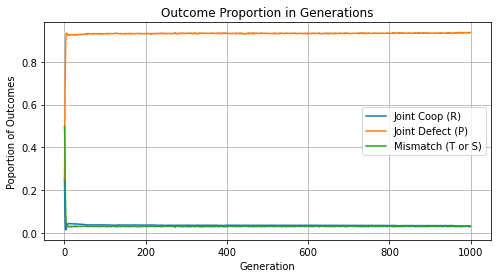

In [12]:
# Assuming the second dimension of payoff_institutions represents time
# We will plot the mean values over time for P, R, and T

# Calculating mean values over time

# Time points (assuming equal intervals)
time_points = np.arange(payoff_institutions.shape[1])

# Creating a line graph
plt.figure(figsize=(8, 4))
plt.plot(time_points, np.mean(outcome_ratios[:, :, :, 0], axis=(0,2)), label='Joint Coop (R)')
plt.plot(time_points, np.mean(outcome_ratios[:, :, :, 3], axis=(0,2)), label='Joint Defect (P)')
plt.plot(time_points, np.mean(outcome_ratios[:, :, :, 1:3].sum(axis = 3), axis=(0,2)), label='Mismatch (T or S)')

plt.grid(True)
plt.xlabel('Generation')
plt.ylabel('Poportion of Outcomes')
plt.title('Outcome Proportion in Generations')
plt.legend()

plt.show()

## Cooperation Landscape 3D plots

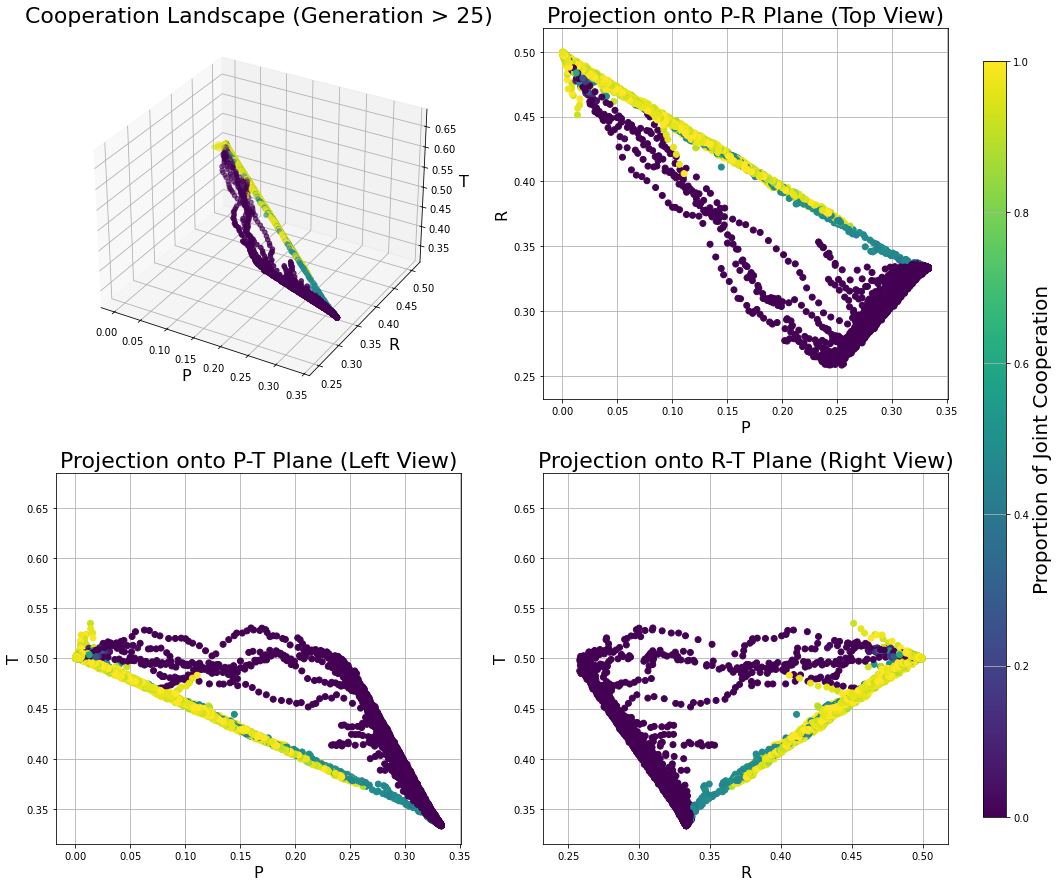

In [13]:
# Looping for 3D scatter plot with projection
# Coordinates for the points to annotate
generations = [25]
for gen in generations:        
    gen_start = gen

    ## Slice or Interval
    # gen_end = gen + 2
    gen_end = None

    # Cooperation
    color = outcome_ratios[:,gen_start:gen_end,:,0].mean(axis = 2).flatten()
    color_label = 'Cooperation'

    # # Payoff
    # color = payoffs[:,gen_start:gen_end].flatten()
    # color_label = 'Received Payoff'

    if gen_end:
        plot_label = color_label + f' Landscape (Generation {gen+1})'
    else:
        plot_label = color_label + f' Landscape (Generation > {gen})'

    P = payoff_institutions[:, gen_start:gen_end, :, 0].mean(axis = 2).flatten()
    R = payoff_institutions[:, gen_start:gen_end, :, 1].mean(axis = 2).flatten()
    T = payoff_institutions[:, gen_start:gen_end, :, 2].mean(axis = 2).flatten()


    if color_label == 'Cooperation':
        color_label = 'Proportion of Joint Cooperation'
        vmax=1
    elif color_label == 'Received Payoff':
        vmax=0.5
        
    # Set bounds for view
    P_max = 1/3 + 0.018
    P_min = -0.018
    R_max = 1/2 + 0.018
    R_min = 1/4 - 0.018
    T_max = 2/3 + 0.018
    T_min = 1/3 - 0.018

    # Creating a new figure for subplots
    fig = plt.figure(figsize=(16, 15))
    # plt.suptitle('Last Generation, Endogenous Payoff Landscape: Received Payoff', fontsize = 22)
    # 3D Scatter plot
    ax1 = fig.add_subplot(221, projection='3d')
    sc = ax1.scatter(P, R, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax1.set_xlabel('P', fontsize = 16)
    ax1.set_ylabel('R', fontsize = 16)
    ax1.set_zlabel('T', fontsize = 16)
    ax1.set_title(plot_label, fontsize = 22)
    ax1.set_xlim3d(P_min, P_max)
    ax1.set_ylim3d(R_min, R_max)
    ax1.set_zlim3d(T_min, T_max)

    # 2D Projection onto the P-R plane
    ax2 = fig.add_subplot(222)
    ax2.grid(True)
    ax2.set_axisbelow(True)
    sc2 = ax2.scatter(P, R, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax2.set_xlabel('P', fontsize = 16)
    ax2.set_ylabel('R', fontsize = 16)
    ax2.set_title('Projection onto P-R Plane (Top View)', fontsize = 22)
    ax2.set_xlim(P_min, P_max)
    ax2.set_ylim(R_min, R_max)

    # 2D Projection onto the P-T plane
    ax3 = fig.add_subplot(223)
    ax3.grid(True)
    ax3.set_axisbelow(True)
    sc3 = ax3.scatter(P, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax3.set_xlabel('P', fontsize = 16)
    ax3.set_ylabel('T', fontsize = 16)
    ax3.set_title('Projection onto P-T Plane (Left View)', fontsize = 22)
    ax3.set_xlim(P_min, P_max)
    ax3.set_ylim(T_min, T_max)

    # 2D Projection onto the R-T plane
    ax4 = fig.add_subplot(224)
    ax4.grid(True)
    ax4.set_axisbelow(True)
    sc4 = ax4.scatter(R, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax4.set_xlabel('R', fontsize = 16)
    ax4.set_ylabel('T', fontsize = 16)
    ax4.set_title('Projection onto R-T Plane (Right View)', fontsize = 22)
    ax4.set_xlim(R_min, R_max)
    ax4.set_ylim(T_min, T_max)

    # Adding a color bar for the entire figure to the right
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label(color_label, fontsize = 20)  # Adjusting font size here

    # Adjusting layout
    plt.subplots_adjust(right=0.9)
    plt.grid(True)
    # Show plot
    plt.show()

Dots show a population in a generation. Lighter color means more outcomes with joint cooperation in that population at that generation.

We get clear clusters in the population-level behavior

### Coooperation Progression

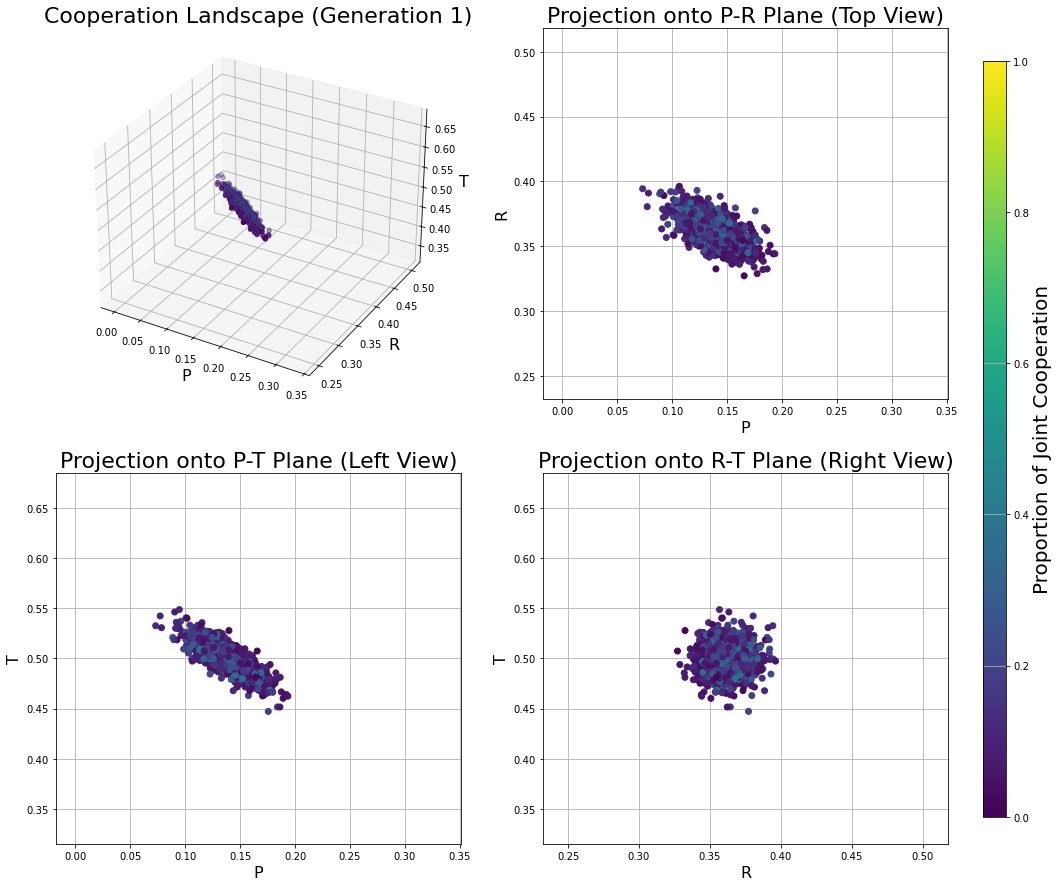

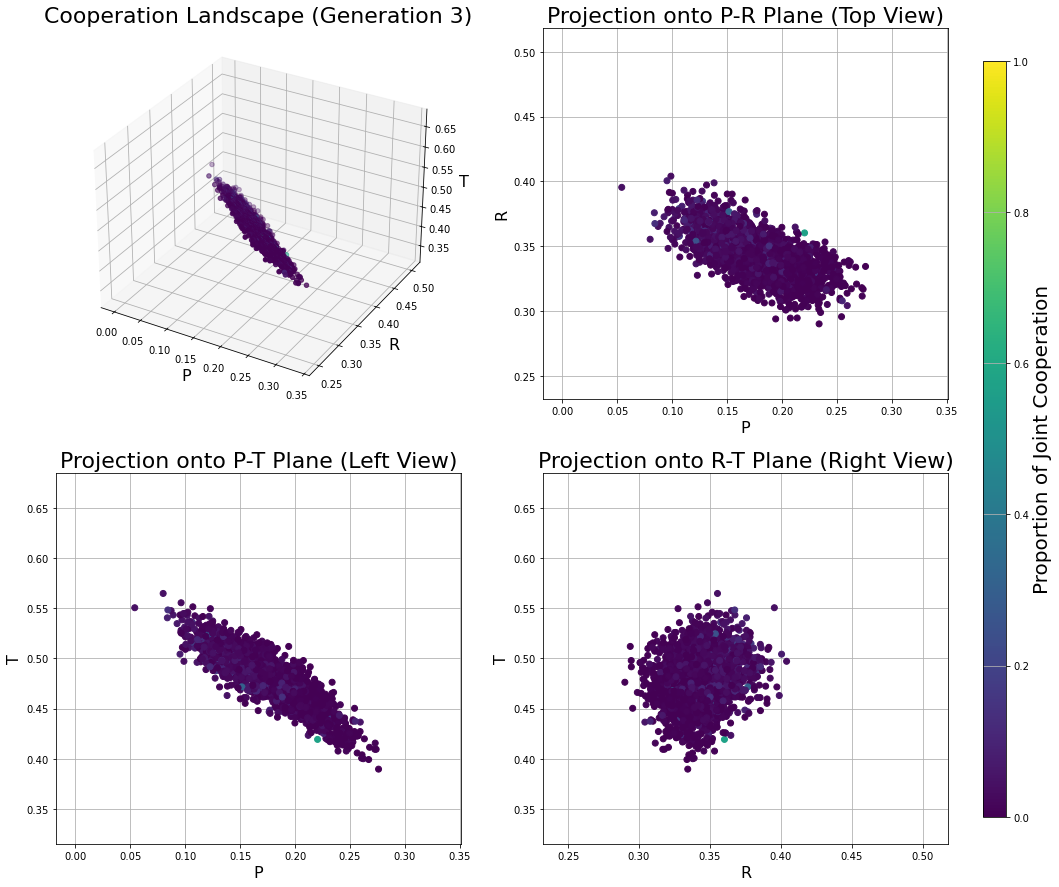

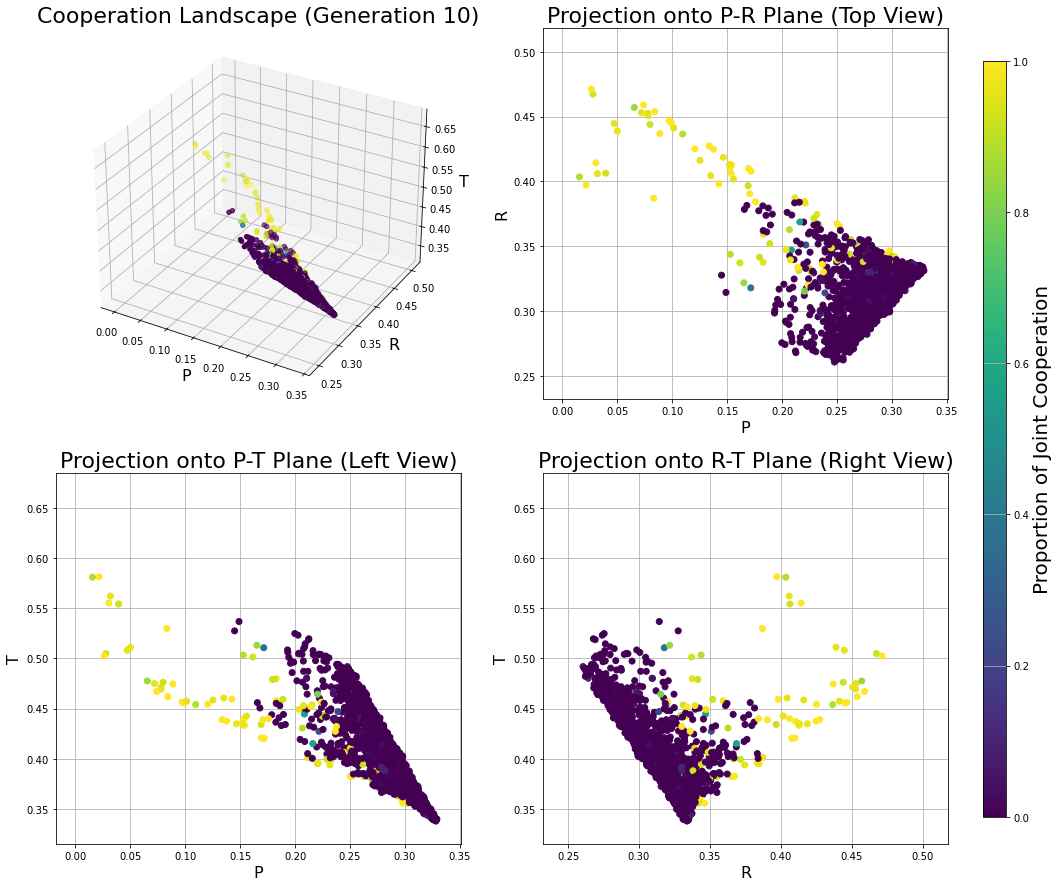

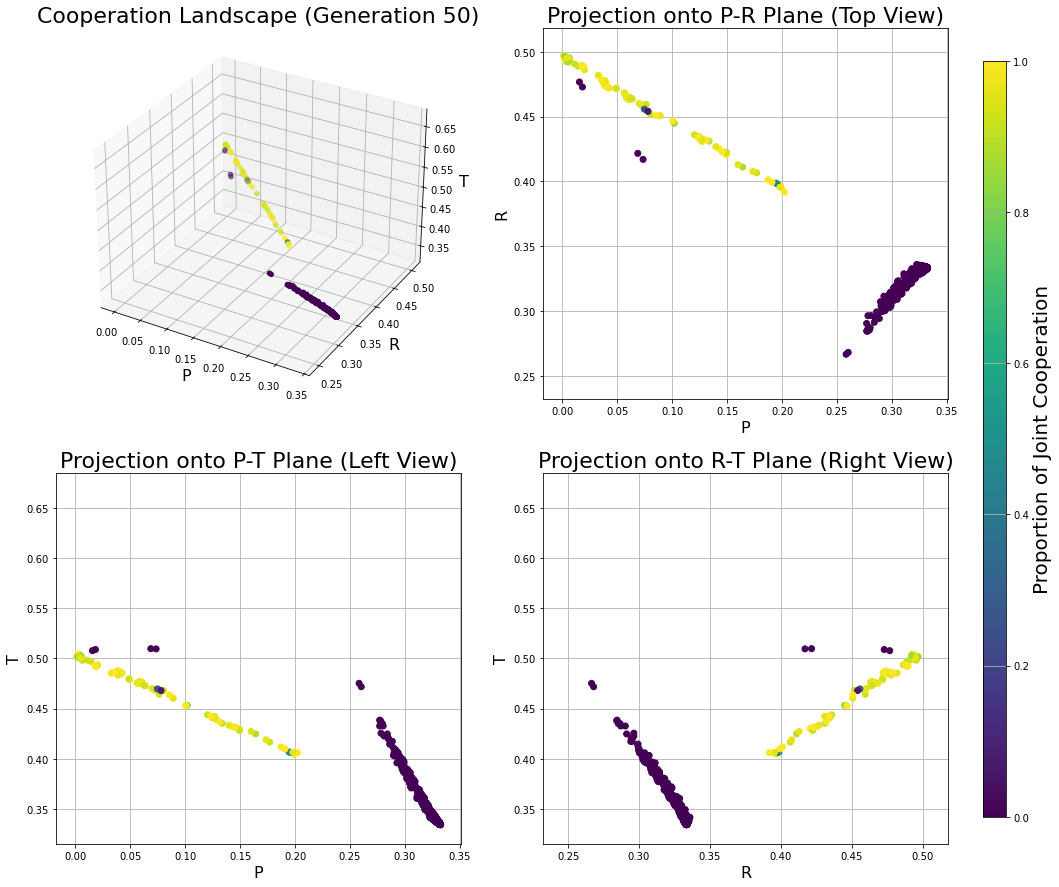

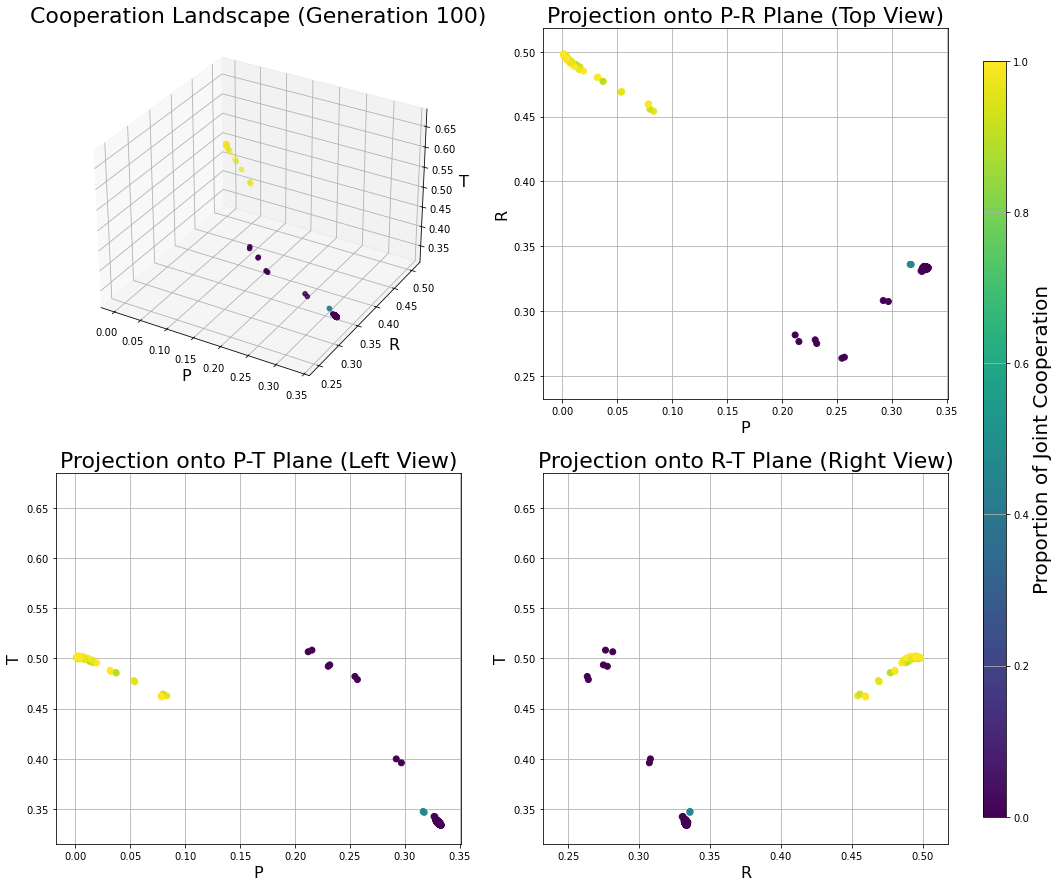

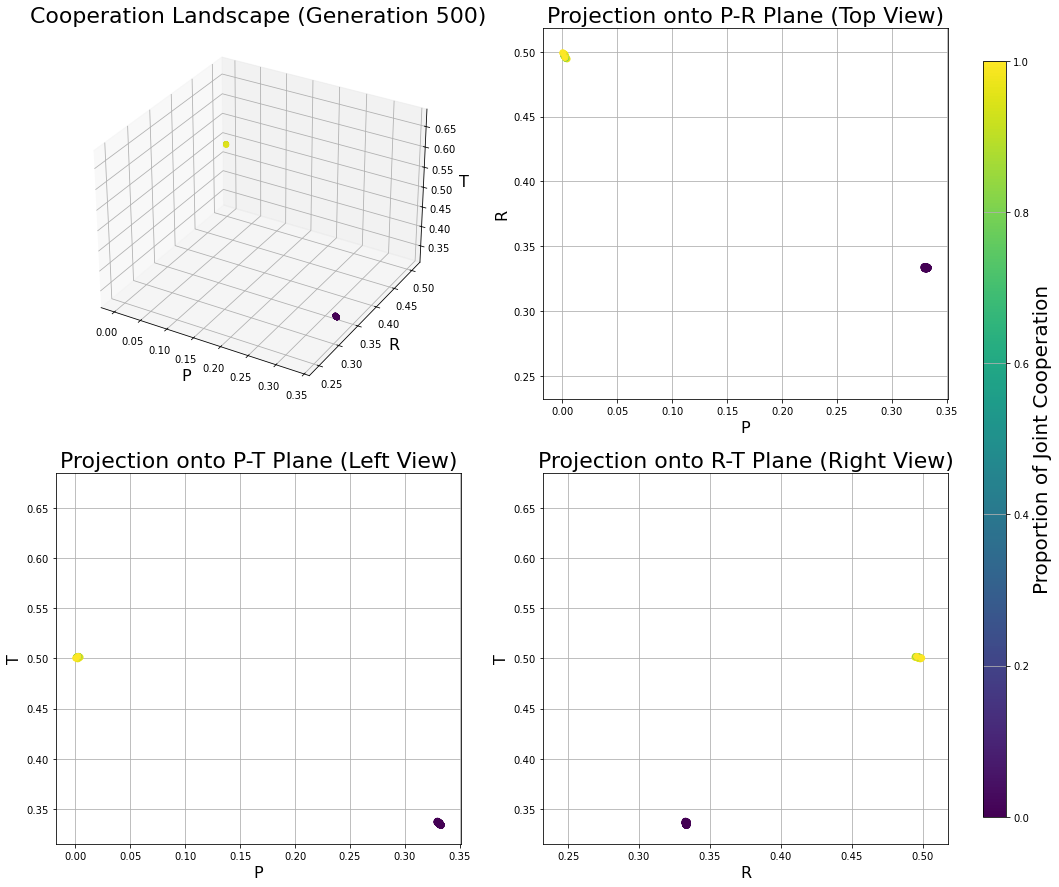

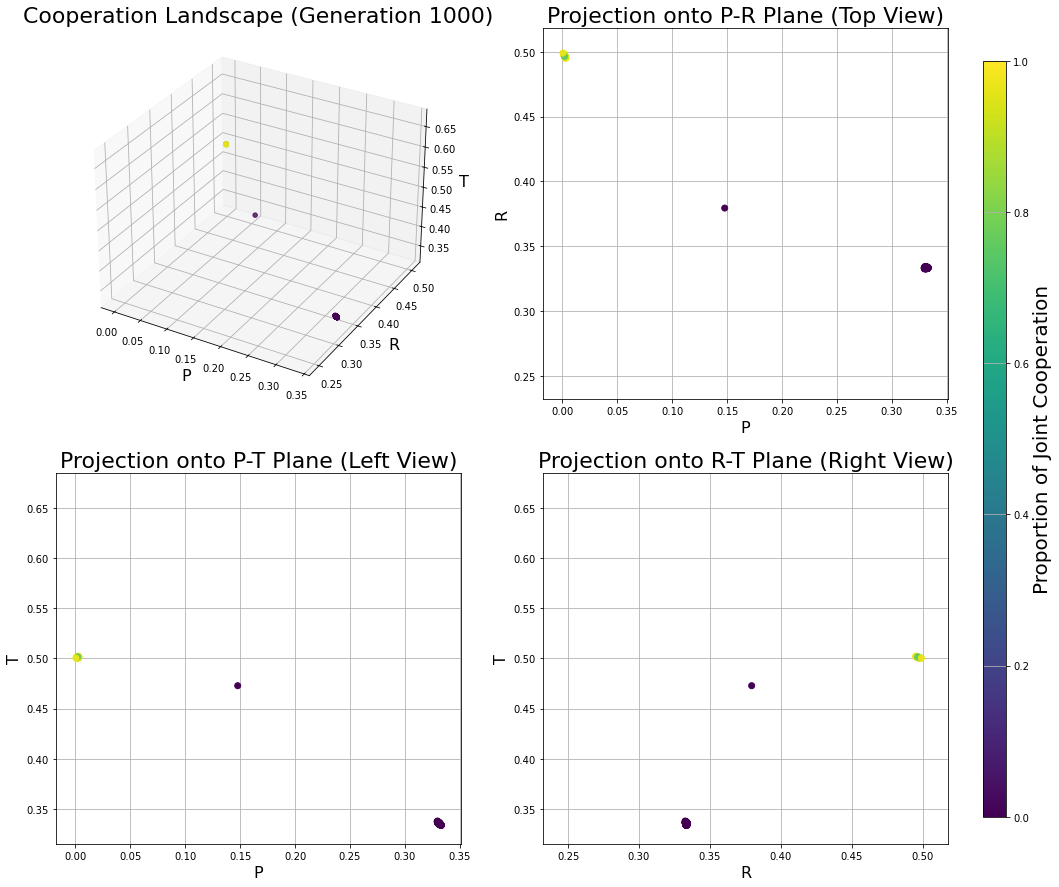

In [18]:
# Adjusting the layout to place the color bar on the right side of the subplots
# Coordinates for the points to annotate
generations = [0, 2, 9, 49, 99, 499, 999]
for gen in generations:        
    gen_start = gen

    ## Slice or Interval
    gen_end = gen + 2
    # gen_end = None

    # Cooperation
    color = outcome_ratios[:,gen_start:gen_end,:,0].mean(axis = 2).flatten()
    color_label = 'Cooperation'

    # # Payoff
    # color = payoffs[:,gen_start:gen_end].flatten()
    # color_label = 'Received Payoff'

    if gen_end:
        plot_label = color_label + f' Landscape (Generation {gen+1})'
    else:
        plot_label = color_label + f' Landscape (Generation > {gen})'

    P = payoff_institutions[:, gen_start:gen_end, :, 0].mean(axis = 2).flatten()
    R = payoff_institutions[:, gen_start:gen_end, :, 1].mean(axis = 2).flatten()
    T = payoff_institutions[:, gen_start:gen_end, :, 2].mean(axis = 2).flatten()


    if color_label == 'Cooperation':
        color_label = 'Proportion of Joint Cooperation'
        vmax=1
    elif color_label == 'Received Payoff':
        vmax=0.5

    # Set bounds for view
    P_max = 1/3 + 0.018
    P_min = -0.018
    R_max = 1/2 + 0.018
    R_min = 1/4 - 0.018
    T_max = 2/3 + 0.018
    T_min = 1/3 - 0.018

    # Creating a new figure for subplots
    fig = plt.figure(figsize=(16, 15))
    # plt.suptitle('Last Generation, Endogenous Payoff Landscape: Received Payoff', fontsize = 22)
    # 3D Scatter plot
    ax1 = fig.add_subplot(221, projection='3d')
    sc = ax1.scatter(P, R, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax1.set_xlabel('P', fontsize = 16)
    ax1.set_ylabel('R', fontsize = 16)
    ax1.set_zlabel('T', fontsize = 16)
    ax1.set_title(plot_label, fontsize = 22)
    ax1.set_xlim3d(P_min, P_max)
    ax1.set_ylim3d(R_min, R_max)
    ax1.set_zlim3d(T_min, T_max)

    # 2D Projection onto the P-R plane
    ax2 = fig.add_subplot(222)
    ax2.grid(True)
    ax2.set_axisbelow(True)
    sc2 = ax2.scatter(P, R, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax2.set_xlabel('P', fontsize = 16)
    ax2.set_ylabel('R', fontsize = 16)
    ax2.set_title('Projection onto P-R Plane (Top View)', fontsize = 22)
    ax2.set_xlim(P_min, P_max)
    ax2.set_ylim(R_min, R_max)

    # 2D Projection onto the P-T plane
    ax3 = fig.add_subplot(223)
    ax3.grid(True)
    ax3.set_axisbelow(True)
    sc3 = ax3.scatter(P, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax3.set_xlabel('P', fontsize = 16)
    ax3.set_ylabel('T', fontsize = 16)
    ax3.set_title('Projection onto P-T Plane (Left View)', fontsize = 22)
    ax3.set_xlim(P_min, P_max)
    ax3.set_ylim(T_min, T_max)

    # 2D Projection onto the R-T plane
    ax4 = fig.add_subplot(224)
    ax4.grid(True)
    ax4.set_axisbelow(True)
    sc4 = ax4.scatter(R, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax4.set_xlabel('R', fontsize = 16)
    ax4.set_ylabel('T', fontsize = 16)
    ax4.set_title('Projection onto R-T Plane (Right View)', fontsize = 22)
    ax4.set_xlim(R_min, R_max)
    ax4.set_ylim(T_min, T_max)

    # Adding a color bar for the entire figure to the right
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label(color_label, fontsize = 20)  # Adjusting font size here


    # Adjusting layout
    plt.subplots_adjust(right=0.9)
    plt.grid(True)
    # Show plot
    plt.show()

## Payoff Landscape 3D Plot

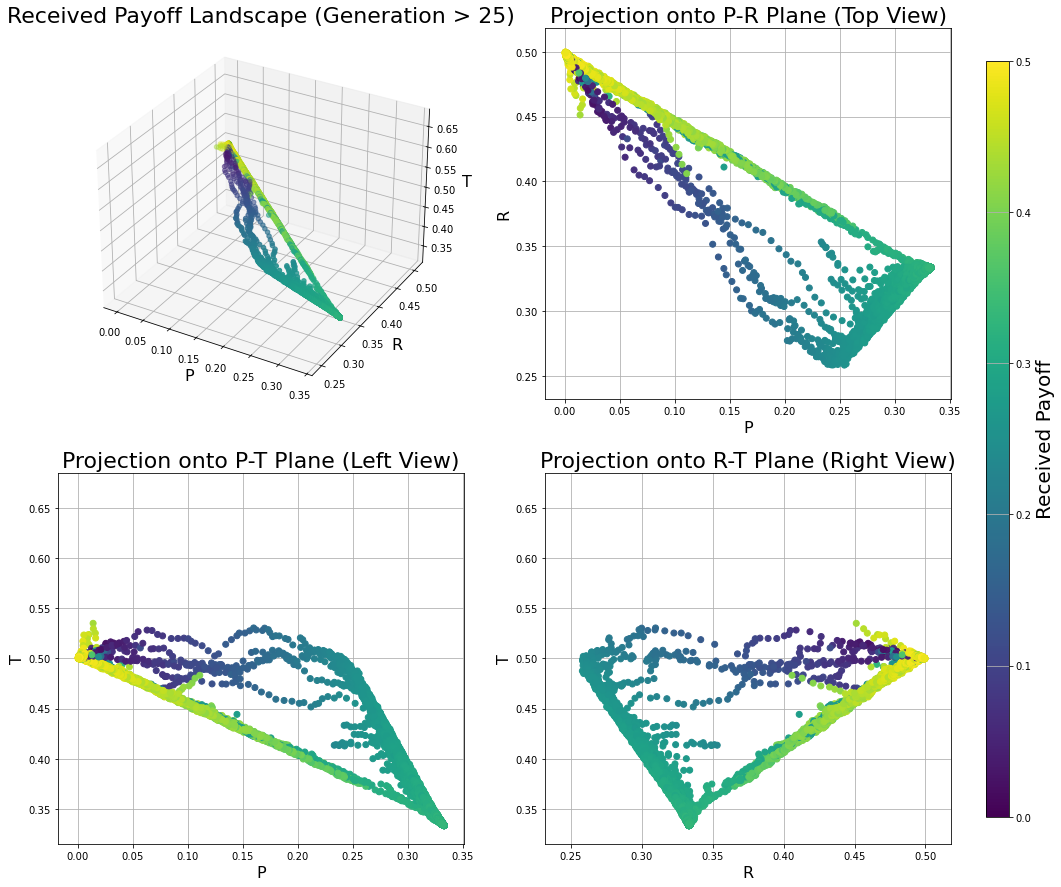

In [39]:
# Looping for 3D scatter plot with projection
# Coordinates for the points to annotate
generations = [25]
for gen in generations:        
    gen_start = gen

    ## Slice or Interval
    # gen_end = gen + 2
    gen_end = None

    # # Cooperation
    # color = outcome_ratios[:,gen_start:gen_end,:,0].mean(axis = 2).flatten()
    # color_label = 'Cooperation'

    # Payoff
    color = payoffs[:,gen_start:gen_end].flatten()
    color_label = 'Received Payoff'

    if gen_end:
        plot_label = color_label + f' Landscape (Generation {gen+1})'
    else:
        plot_label = color_label + f' Landscape (Generation > {gen})'

    P = payoff_institutions[:, gen_start:gen_end, :, 0].mean(axis = 2).flatten()
    R = payoff_institutions[:, gen_start:gen_end, :, 1].mean(axis = 2).flatten()
    T = payoff_institutions[:, gen_start:gen_end, :, 2].mean(axis = 2).flatten()


    if color_label == 'Cooperation':
        color_label = 'Proportion of Joint Cooperation'
        vmax=1
    elif color_label == 'Received Payoff':
        vmax=0.5
        
    # Set bounds for view
    P_max = 1/3 + 0.018
    P_min = -0.018
    R_max = 1/2 + 0.018
    R_min = 1/4 - 0.018
    T_max = 2/3 + 0.018
    T_min = 1/3 - 0.018

    # Creating a new figure for subplots
    fig = plt.figure(figsize=(16, 15))
    # plt.suptitle('Last Generation, Endogenous Payoff Landscape: Received Payoff', fontsize = 22)
    # 3D Scatter plot
    ax1 = fig.add_subplot(221, projection='3d')
    sc = ax1.scatter(P, R, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax1.set_xlabel('P', fontsize = 16)
    ax1.set_ylabel('R', fontsize = 16)
    ax1.set_zlabel('T', fontsize = 16)
    ax1.set_title(plot_label, fontsize = 22)
    ax1.set_xlim3d(P_min, P_max)
    ax1.set_ylim3d(R_min, R_max)
    ax1.set_zlim3d(T_min, T_max)

    # 2D Projection onto the P-R plane
    ax2 = fig.add_subplot(222)
    ax2.grid(True)
    ax2.set_axisbelow(True)
    sc2 = ax2.scatter(P, R, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax2.set_xlabel('P', fontsize = 16)
    ax2.set_ylabel('R', fontsize = 16)
    ax2.set_title('Projection onto P-R Plane (Top View)', fontsize = 22)
    ax2.set_xlim(P_min, P_max)
    ax2.set_ylim(R_min, R_max)

    # 2D Projection onto the P-T plane
    ax3 = fig.add_subplot(223)
    ax3.grid(True)
    ax3.set_axisbelow(True)
    sc3 = ax3.scatter(P, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax3.set_xlabel('P', fontsize = 16)
    ax3.set_ylabel('T', fontsize = 16)
    ax3.set_title('Projection onto P-T Plane (Left View)', fontsize = 22)
    ax3.set_xlim(P_min, P_max)
    ax3.set_ylim(T_min, T_max)

    # 2D Projection onto the R-T plane
    ax4 = fig.add_subplot(224)
    ax4.grid(True)
    ax4.set_axisbelow(True)
    sc4 = ax4.scatter(R, T, c=color, cmap='viridis', vmin = 0.0, vmax = vmax)
    ax4.set_xlabel('R', fontsize = 16)
    ax4.set_ylabel('T', fontsize = 16)
    ax4.set_title('Projection onto R-T Plane (Right View)', fontsize = 22)
    ax4.set_xlim(R_min, R_max)
    ax4.set_ylim(T_min, T_max)

    # Adding a color bar for the entire figure to the right
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label(color_label, fontsize = 20)  # Adjusting font size here

    # Adjusting layout
    plt.subplots_adjust(right=0.9)
    plt.grid(True)
    # Show plot
    plt.show()

Dots show a population in a generation. Lighter color means higher average payoff.

Good to be at (0, 1/2, 1/2) or (1/3, 1/3, 1/3), cooperation has a higher reward, so (0, 1/2, 1/2) is the best. 

What is happening to the populations gettign near 0 payoff near (0, 1/2, 1/2)?

## The Worst Thing is When Cooperation Collapses

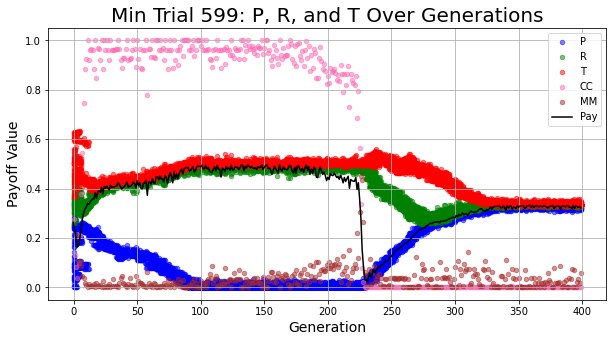

In [38]:
# Assuming the second dimension of payoff_institutions represents time
# We will plot the mean values over time for P, R, and T
trials = [np.argsort((payoff_institutions[:, 200, :, 0] \
                   - payoff_institutions[:, 400, :, 0]).mean(axis = 1))[0]]
for trial in trials:
    
    # Calculating mean values over time
    CC = outcome_ratios[trial, :400, :, 0].mean(axis = 1).flatten()
    MM = outcome_ratios[trial, :400, :, 1:3].sum(axis = 2).mean(axis = 1).flatten()
    P = payoff_institutions[trial, :400, :, 0].flatten()
    R = payoff_institutions[trial, :400, :, 1].flatten()
    T = payoff_institutions[trial, :400, :, 2].flatten()

    # Time points (assuming equal intervals)
    a = np.ones((400, payoff_institutions.shape[2]))
    b = np.arange(400)
    time_points = (a * b[:, np.newaxis]).flatten()

    # Creating a line graph
    plt.figure(figsize=(10, 5))
    plt.scatter(time_points, P, label='P', alpha = 0.5, color='blue', s = 20)
    plt.scatter(time_points, R, label='R', alpha = 0.5, color='green', s = 20)
    plt.scatter(time_points, T, label='T', alpha = 0.5, color='red', s = 20)
    plt.scatter(np.arange(CC.shape[0]), CC, label='CC', color='hotpink', alpha=0.5, s = 20)
    plt.scatter(np.arange(CC.shape[0]), MM, label='MM', color='brown', alpha=0.5, s = 20)
    plt.plot(np.arange(400), payoffs[trial, :400], label = 'Pay', color = 'black')

    plt.grid(True)
    plt.xlabel('Generation', fontsize = 14)
    plt.ylabel('Payoff Value', fontsize = 14)
    plt.title(f'Min Trial {trial}: P, R, and T Over Generations', fontsize = 20)
    plt.legend()

    plt.show()

Graph shows a single population. Blue, green, and red dots show a single agent from one trial in a generation.

CC denotes the percent of games with joint cooperation. MM denotes the percent of games where someone gets duped. 1 - CC - MM = percent of games with joint defection.

Pay denotes the average payoff of the population. 

## Experiment Overview

#### 10 Rounds

In [16]:
print('                       P    R     T')
print(f'Insitution Values: {np.round(payoff_institutions.mean(axis = (0,1,2)), 3)}')
print('                      CC    CD     DC   DD')
print(f' All Gen Outcomes: {100*np.round(outcome_ratios.mean(axis = (0,1,2)), 4)}')
print(f'Last Gen Outcomes: {100*np.round(outcome_ratios[:,-1].mean(axis = (0,1)), 4)}')

print()
print(f'Average Payoffs: {np.round(payoffs.mean(), 4)}')

                       P    R     T
Insitution Values: [0.168 0.168 0.18 ]
                      CC    CD     DC   DD
 All Gen Outcomes: [ 3.68  1.62  1.62 93.07]
Last Gen Outcomes: [ 3.3   1.49  1.52 93.68]

Average Payoffs: 0.33


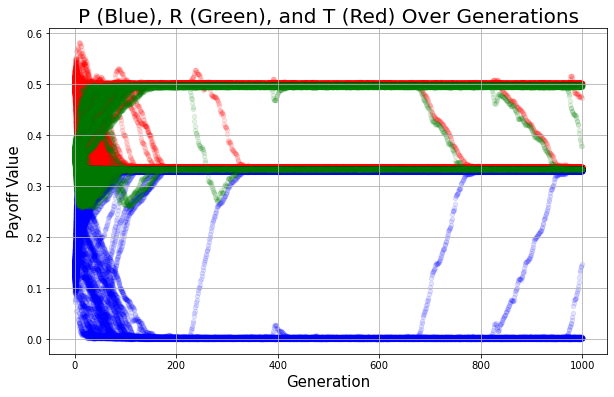

In [14]:
# Calculating mean values over time
P = payoff_institutions[:, :, :, 0].mean(axis = 2).flatten()
R = payoff_institutions[:, :, :, 1].mean(axis = 2).flatten()
T = payoff_institutions[:, :, :, 2].mean(axis = 2).flatten()

# Time points (assuming equal intervals)
a = np.ones((payoff_institutions.shape[0], payoff_institutions.shape[1]))
b = np.arange(payoff_institutions.shape[1])
time_points = (a * b[np.newaxis, :]).flatten()

# Creating a line graph
plt.figure(figsize=(10, 6))
plt.scatter(time_points, T, label='T Payoff', alpha = 0.1, color='red', s = 20)
plt.scatter(time_points, P, label='P Payoff', alpha = 0.1, color='blue', s = 20)
plt.scatter(time_points, R, label='R Payoff', alpha = 0.1, color='green', s = 20)

# plt.plot(time_points, np.mean(payoffs, axis = 0), label = 'Received Payoff', color = 'black')

plt.grid(True)
plt.xlabel('Generation', fontsize = 15)
plt.ylabel('Payoff Value', fontsize = 15)
plt.title('P (Blue), R (Green), and T (Red) Over Generations', fontsize = 20)

plt.show()

Dots show a population average in a generation.

## 1000 Rounds

In [43]:
print("                       P    R     T\n\
Insitution Values: [0.168 0.168 0.224]\n\
                      CC    CD     DC   DD\n\
 All Gen Outcomes: [18.68  1.51  1.51 78.29]\n\
Last Gen Outcomes: [18.49  1.49  1.5  78.53]\n\n\
\
Average Payoffs: 0.3505\n\
")

                       P    R     T
Insitution Values: [0.168 0.168 0.224]
                      CC    CD     DC   DD
 All Gen Outcomes: [18.68  1.51  1.51 78.29]
Last Gen Outcomes: [18.49  1.49  1.5  78.53]

Average Payoffs: 0.3505



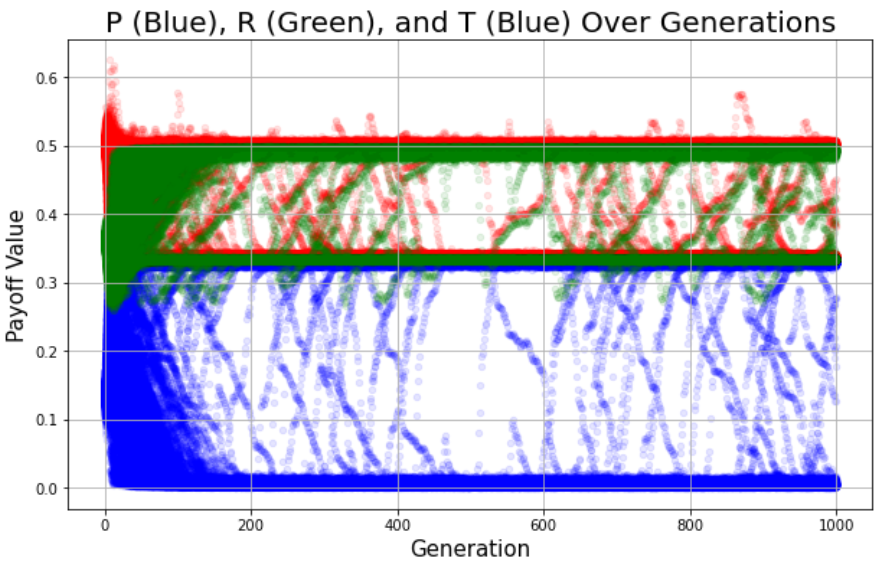

Dots show a population average in a generation.

## Conclusions
1) Cooperation is quite difficult but possible to maintain on finite time scales
2) More rounds increases cooperation, but only so much
2) Agents' institutions follow their strategy in evolution, moving toward maximizing their strategy's payoff
3) The collapse of cooperation produces the worst outcomes (worse than imediately coming to a defective equilbrium on small enough time scales)